<a href="https://colab.research.google.com/github/akfangus/DeepProject/blob/main/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
train_set = torchvision.datasets.CIFAR10('./datasets', train=True, 
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False, 
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, 
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, 
                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


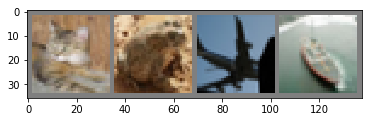

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:4]))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda


In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

![image.png](attachment:image.png)

In [ ]:
class VGG(nn.Module):
    
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
        self._initialize_weight()
        
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # xavier is used in VGG's paper
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

## VGG16 structure
![image.png](attachment:image.png)

In [ ]:
net = VGG('VGG16').to(device)
print(net)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [ ]:
x = torch.randn(2, 3, 32, 32).to(device)
y = net(x)
print(y.shape)

torch.Size([2, 10])


In [ ]:
lr = 1e-3
momentum = 0.9
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

In [ ]:
# Training
def train(epoch):
    print('\nEpoch: %d' % (epoch + 1))
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.5f |  Acc: %.3f%% (%d/%d)' %
                  (epoch + 1, batch_idx + 1, train_loss / 2000, 100.*correct/total, correct, total))
            train_loss = 0.0
            total = 0
            correct = 0

In [ ]:
load_model = True
if load_model:
    checkpoint = torch.load('./checkpoint/vgg.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

start_epoch: 85


In [ ]:
for epoch in range(start_epoch, 200):
    train(epoch)
    start_epoch = epoch


Epoch: 87
[87,   100] loss: 0.00020 |  Acc: 99.930% (12791/12800)
[87,   200] loss: 0.00022 |  Acc: 99.922% (12790/12800)
[87,   300] loss: 0.00019 |  Acc: 99.922% (12790/12800)

Epoch: 88
[88,   100] loss: 0.00015 |  Acc: 99.969% (12796/12800)
[88,   200] loss: 0.00018 |  Acc: 99.945% (12793/12800)
[88,   300] loss: 0.00017 |  Acc: 99.969% (12796/12800)

Epoch: 89
[89,   100] loss: 0.00013 |  Acc: 99.961% (12795/12800)
[89,   200] loss: 0.00012 |  Acc: 99.992% (12799/12800)
[89,   300] loss: 0.00013 |  Acc: 99.992% (12799/12800)

Epoch: 90
[90,   100] loss: 0.00011 |  Acc: 99.984% (12798/12800)
[90,   200] loss: 0.00010 |  Acc: 99.984% (12798/12800)
[90,   300] loss: 0.00010 |  Acc: 99.992% (12799/12800)

Epoch: 91
[91,   100] loss: 0.00010 |  Acc: 99.992% (12799/12800)
[91,   200] loss: 0.00010 |  Acc: 100.000% (12800/12800)
[91,   300] loss: 0.00010 |  Acc: 99.992% (12799/12800)

Epoch: 92
[92,   100] loss: 0.00009 |  Acc: 99.992% (12799/12800)
[92,   200] loss: 0.00008 |  Acc: 100

[131,   300] loss: 0.00004 |  Acc: 100.000% (12800/12800)

Epoch: 132
[132,   100] loss: 0.00004 |  Acc: 100.000% (12800/12800)
[132,   200] loss: 0.00005 |  Acc: 99.992% (12799/12800)
[132,   300] loss: 0.00004 |  Acc: 100.000% (12800/12800)

Epoch: 133
[133,   100] loss: 0.00004 |  Acc: 100.000% (12800/12800)
[133,   200] loss: 0.00005 |  Acc: 100.000% (12800/12800)
[133,   300] loss: 0.00005 |  Acc: 99.992% (12799/12800)

Epoch: 134
[134,   100] loss: 0.00004 |  Acc: 100.000% (12800/12800)
[134,   200] loss: 0.00004 |  Acc: 100.000% (12800/12800)
[134,   300] loss: 0.00004 |  Acc: 100.000% (12800/12800)

Epoch: 135
[135,   100] loss: 0.00005 |  Acc: 100.000% (12800/12800)
[135,   200] loss: 0.00004 |  Acc: 100.000% (12800/12800)
[135,   300] loss: 0.00004 |  Acc: 100.000% (12800/12800)

Epoch: 136
[136,   100] loss: 0.00004 |  Acc: 100.000% (12800/12800)
[136,   200] loss: 0.00005 |  Acc: 100.000% (12800/12800)
[136,   300] loss: 0.00004 |  Acc: 100.000% (12800/12800)

Epoch: 137
[1


Epoch: 176
[176,   100] loss: 0.00005 |  Acc: 100.000% (12800/12800)
[176,   200] loss: 0.00005 |  Acc: 100.000% (12800/12800)
[176,   300] loss: 0.00005 |  Acc: 99.992% (12799/12800)

Epoch: 177
[177,   100] loss: 0.00004 |  Acc: 100.000% (12800/12800)
[177,   200] loss: 0.00004 |  Acc: 100.000% (12800/12800)
[177,   300] loss: 0.00005 |  Acc: 100.000% (12800/12800)

Epoch: 178
[178,   100] loss: 0.00004 |  Acc: 100.000% (12800/12800)
[178,   200] loss: 0.00005 |  Acc: 100.000% (12800/12800)
[178,   300] loss: 0.00004 |  Acc: 100.000% (12800/12800)

Epoch: 179
[179,   100] loss: 0.00005 |  Acc: 100.000% (12800/12800)
[179,   200] loss: 0.00004 |  Acc: 100.000% (12800/12800)
[179,   300] loss: 0.00004 |  Acc: 100.000% (12800/12800)

Epoch: 180
[180,   100] loss: 0.00005 |  Acc: 99.992% (12799/12800)
[180,   200] loss: 0.00004 |  Acc: 100.000% (12800/12800)
[180,   300] loss: 0.00005 |  Acc: 100.000% (12800/12800)

Epoch: 181
[181,   100] loss: 0.00005 |  Acc: 100.000% (12800/12800)
[1

In [ ]:
save_model = True
if save_model:
    state = {
        'net': net.state_dict(),
        'epoch': epoch,
    }
    os.makedirs('checkpoint', exist_ok=True)
    torch.save(state, './checkpoint/vgg.ckpt')

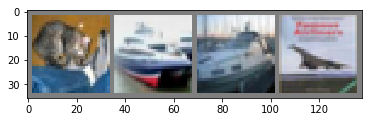

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship   car plane
Accuracy of the network on the 10000 test images: 90 %
Accuracy of plane : 95 %
Accuracy of   car : 100 %
Accuracy of  bird : 81 %
Accuracy of   cat : 79 %
Accuracy of  deer : 91 %
Accuracy of   dog : 90 %
Accuracy of  frog : 90 %
Accuracy of horse : 96 %
Accuracy of  ship : 89 %
Accuracy of truck : 93 %


In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))